Global seed set to 0


(Running UniTVelo 0.2.5.2)
2024-02-08 12:16:22


2024-02-08 12:16:25.516397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 12:16:25.516475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 12:16:25.594788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Keeping at most 100000 cells per cluster


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Filtered out 20300 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Leiden clustering ...
Number of Leiden Clusters: 8
Maximal Number of Modules: 9


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 13.04it/s]
Computing total RNAvelocity ...
# Cross-Boundary Direction Correctness (A->B)
{('dividing', 'progenitors'): 0.5625346127804496, ('progenitors', 'activating'): 0.7765566158463859}
Total Mean: 0.6695456143134177
# In-cluster Coherence
{'B cell lineage': 0.6261398, 'activating': 0.93073744, 'dividing': 0.9243816, 'macrophages': 0.60123813, 'progenitors': 0.83902854}
Total Mean: 0.7843051552772522


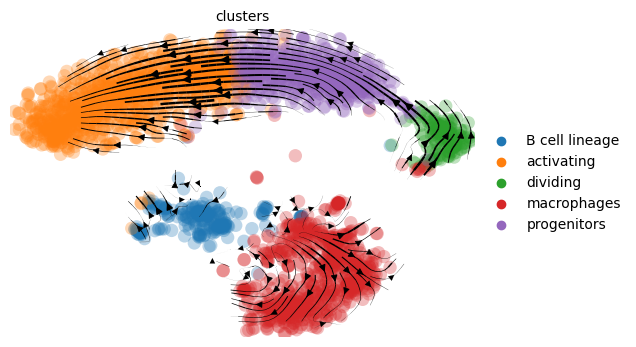

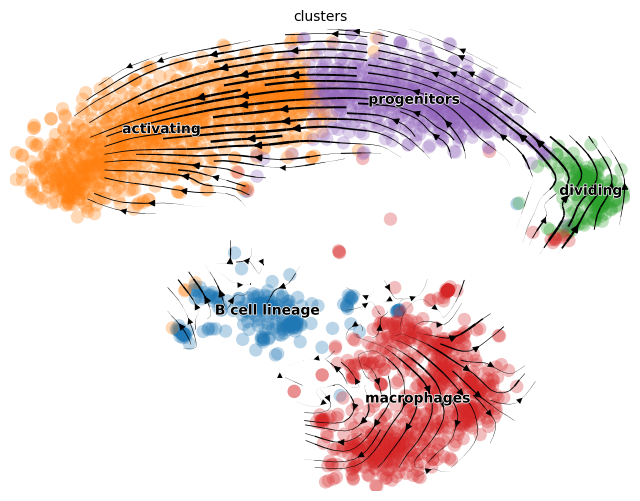

In [1]:
import os
os.chdir('..')
import scvelo as scv
import scanpy as sc
import cell2fate as c2f
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
import time

method = 'cell2fate'
datasets = datasets = ['Pancreas_with_cc', 'DentateGyrus' , 'MouseErythroid', 'MouseBoneMarrow', 'HumanBoneMarrow', 'HumanDevelopingBrain']
batch_id = [None, None, 'sequencing.batch', None, None, 'Sanger_sample_ID']
Tmax_prior_mean = [50., 50., 50., 50., 500., 50.]
Tmax_prior_sd = [50., 50., 50., 50., 100., 50.]
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results_revision/'

i = 3
dataset = datasets[i]
adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
start = time.time()
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                remove_clusters = [], min_shared_counts = 20, n_var_genes= 3000)
if batch_id[i]:
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                          batch_key = batch_id[i])
else:
    c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')    
n_modules = c2f.utils.get_max_modules(adata)
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules,
                                   Tmax_prior={"mean": Tmax_prior_mean[i], "sd": Tmax_prior_sd[i]})
mod.train()
adata = mod.export_posterior(adata)
end = time.time()
mod.compute_and_plot_total_velocity(adata, save = False, delete = False)
# Calculate performance metrics:
file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
ground_truth = pickle.load(file)
metrics = utv.evaluate(adata, ground_truth, 'clusters', 'Velocity')
if exists(save_dir + dataset + '_CBDC_scores.csv'):
    tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
else:
    tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean', 'Time'],
             index = [method])
cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
            for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
tab.loc[method,:] = cb_score + [np.mean(cb_score), end-start]
tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax)
plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.svg')
adata.layers['velocity'] = np.array(adata.layers['Velocity'])
del adata.layers['Velocity']
adata.layers['Ms'] = mod.samples['post_sample_means']['mu_expression'][...,0]
adata.layers['Mu'] = mod.samples['post_sample_means']['mu_expression'][...,1]
adata.write_h5ad('/nfs/team283/aa16/data/fate_benchmarking/' + method + dataset + 'AnnDataForCellRank.h5ad')

In [2]:
adata.layers['velocity'] = np.array(adata.layers['Velocity'])
del adata.layers['Velocity']
adata.layers['Ms'] = mod.samples['post_sample_means']['mu_expression'][...,0]
adata.layers['Mu'] = mod.samples['post_sample_means']['mu_expression'][...,1]
adata.write_h5ad('/nfs/team283/aa16/data/fate_benchmarking/MouseBoneMarrowAnnDataForCellRank.h5ad')

KeyError: 'Velocity'